### 测试1、BUG，maxiters问题
结论：在设计微分方程的时候没有考虑到弹出阶段可能失败，最后回落的情况，在简化的例子中并没有出现这种情况是因为我直接把这一阶段的force给定了，而在原版中使用的是相对速度来判定，导致刚度的跳动

In [ ]:
using DifferentialEquations, ParameterizedFunctions

In [2]:
function k1k2Force(u, k, fp)
    """ Control law1: using fixed k1, k2 model """
    x0, y0, z0 = fp
    l0 = 0.8
    x, y, z= u[1:3]
    l = sqrt((x-x0)^2 + (y-y0)^2 + (z-0)^2)

    fx = - k * (x - (x0 - l0*(x0-x)/l))
    fy = - k * (y - (y0 - l0*(y0-y)/l))
    fz = - k * (z - ( 0 - l0*(z0-z)/l))
    return (fx, fy, fz)
end
function diff_fun_support!(du, u, p, t)
    """ Differential Equations on ground """
    m, g = 20, 9.8
    k = 5200.697095215387
    p = fp
    x, y, z, vx, vy, vz = u
    
    fx, fy, fz = k1k2Force(u, k, fp)          # force specification
    ax, ay, az = fx/m, fy/m, (fz-m*g)/m
    du[1], du[2], du[3] = vx, vy, vz
    du[4], du[5], du[6] = ax, ay, az
end
function cond_leave(u, t, integrator)
    """ Condition: Leave ground """
    x, y, z = u[1:3]
    x0, y0, z0 = integrator.p
    l = sqrt((x-x0)^2 + (y-y0)^2 + (z-z0)^2)
    return (l - 0.8)
end

cond_leave (generic function with 1 method)

In [27]:
#tspan = 5.0
tspan = (0.0, 4.0)
m, l0 = 20, 0.8
fp = [7.823997180448066e-6, 3.5371522618755984e-6, 3.3306690738754696e-16]
u0 = [-5.338271146042391e-7, -2.413379941638449e-7, 0.7253117214813545, -2.7341388957084536e-5, -1.236077334409694e-5, -3.7944992849002327e-10]

prob = ODEProblem(diff_fun_support!, u0, tspan, fp)
cb = ContinuousCallback(cond_leave, terminate!)
sol3 = solve(prob, Tsit5(), callback=cb, saveat = 0.01);

In [7]:
using Plots

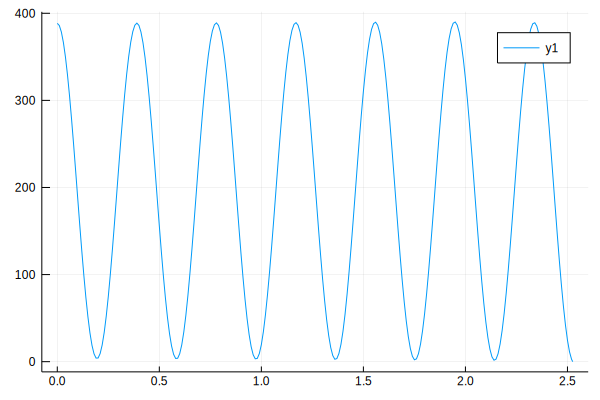

In [26]:
l = []
f = []
k = 5200.697095215387
x0, y0, z0 = fp
for li in sol3.u
    x, y, z= li[1:3]
    lr = sqrt((x-x0)^2 + (y-y0)^2 + (z-0)^2)
    append!(l, lr)
    append!(f, k1k2Force(li, k, fp)[3])
end

plot(sol3.t, f)

#### 原始问题记录
下面记录原始的问题情况，源文档将不保留这部分

In [28]:
function calc_foot_end(u, p)
    """ calculate the foot position in air """
    x, y, z = u[1:3]
    l0, α, β = p[2:4]
    x_pf = x + l0*cos(β)sin(α)
    y_pf = y + l0*sin(β)
    z_pf = z - l0*cos(β)cos(α)
    return (x_pf, y_pf, z_pf)
end
function diff_fun_fly!(du, u, p, t)
    """ Differential Equations in air"""
    x, y, z, vx, vy, vz = u
    g = p[1]
    du[1], du[2], du[3] = dx, dy, dz = vx, vy, vz
    du[4], du[5], du[6] = 0.0, 0.0, -g 
end

cond_contact(u, t, integrator) = calc_foot_end(u, integrator.p)[3]  # positive-->negative
affect_contact!(integrator) = terminate!(integrator)
cond_peak(u, t, integrator) = u[6]
# --------------------------------
function compressingCalc(u, p)
    """ decide if on compressing """
    x, y, z, vx, vy, vz = u
    x0, y0, z0 = p[6:8]
    vec1 = transpose([x-x0, y-y0, z])  # ground-->mass point
    vec2 = [vx, vy, vz]                # velocity vector
    return vec1*vec2
end
function k1k2Force(u, p)
    """ Control law1: using fixed k1, k2 model """
    k1, k2, x0, y0, z0 = p[4:8]
    l0 = p[3]
    x, y, z= u[1:3]
    l = sqrt((x-x0)^2 + (y-y0)^2 + (z-0)^2)
    # 仿真的时候会出现速度为零的情况，这种情况应该被视为？
    # 的确没有想到
    k = compressingCalc(u, p)<0 ? k1 : k2

    fx = - k * (x - (x0 - l0*(x0-x)/l))
    fy = - k * (y - (y0 - l0*(y0-y)/l))
    fz = - k * (z - ( 0 - l0*(z0-z)/l))
    return (fx, fy, fz)
end
function jointForce(u, p)
    """Calculation: k force --> joint force"""
    p1, p2 = p[1], p[2]
    k1, k2, x0, y0, z0 = p2[4:8]
    l0 = p2[3]
    x, y, z= u[1:3]
    l = sqrt((x-x0)^2 + (y-y0)^2 + (z-0)^2)
    k = compressingCalc(u, p2)<=0 ? k1 : k2
    kforce = k*abs(l0-l)
    tmp = l0^2 - l^2
    if tmp < 0
        if tmp > -0.003
            tmp = 0.0
        else
            # 其实在遇到这个问题的时候我不希望仿真结束，而想要记录下这个问题然后继续
            println("error in mass point position:", tmp, ", with", [p1[3], p1[4],k1, k2])
            tmp = 0.0
        end
    end
    torque = kforce * sqrt(tmp)/2
    return torque
end

jointForce (generic function with 1 method)

In [29]:
function diff_fun_support!(du, u, p, t)
    """ Differential Equations on ground """
    m, g = p[1:2]
    x, y, z, vx, vy, vz = u
    
    fx, fy, fz = k1k2Force(u, p)          # force specification
    ax, ay, az = fx/m, fy/m, (fz-m*g)/m
    du[1], du[2], du[3] = vx, vy, vz
    du[4], du[5], du[6] = ax, ay, az
end

function cond_compressed(u, t, integrator)
    x, y, z, vx, vy, vz = u
    x0, y0, z0 = integrator.p[6:8]
    vec1 = transpose([x-x0, y-y0, z])  # ground-->mass point
    vec2 = [vx, vy, vz]                # velocity vector
    return vec1*vec2                   # negative-->positive
end

function cond_leave(u, t, integrator)
    """ Condition: Leave ground """
    x, y, z = u[1:3]
    x0, y0, z0 = integrator.p[6:8]
    l = sqrt((x-x0)^2 + (y-y0)^2 + (z-z0)^2)
    return (l - integrator.p[3])
end

cond_leave (generic function with 1 method)

In [30]:
function cycleCalc(m, l0, s0, ctrl)
    α, β, k1, k2 = ctrl
    z0, vx0, vy0 = s0
    u0 = [0.0, 0.0, z0, vx0, vy0, 0.0]
    tspan = (0.0, 4.0)
    p1 = (9.8, l0, α, β, k1, k2)
    # ------------------------------------------------------
    # segment1, air-->contact
    # the initial foot positon is not supposed to be underground!
    # ------------------------------------------------------
    if(calc_foot_end(u0, p1)[3] <= 0)           # check
        return ([], [], [p1,])
    end
    
    prob = ODEProblem(diff_fun_fly!, u0, tspan, p1)
    cb = ContinuousCallback(cond_contact, affect_contact!)
    sol1 = solve(prob, Tsit5(), callback=cb, saveat = 0.01)
    if(sol1.retcode != :Terminated)
        println("warning1 ctrl here:", ctrl)
    end
    
    # ------------------------------------------------------
    # segment2, compressing
    # if segment1 end with opposite velocity, simulation may get wired!
    # ------------------------------------------------------
    u0 = sol1.u[end]    
    foot_p = calc_foot_end(u0, p1)
    p2 = [m, 9.8, l0, k1, k2, foot_p...]
    if(compressingCalc(u0, p2) > 0)
        return ([sol1,], foot_p, [p1, p2])               # check
    end
    
    prob = ODEProblem(diff_fun_support!, u0, tspan, p2)
    cb = ContinuousCallback(cond_compressed, terminate!)
    sol2 = solve(prob, Tsit5(), callback=cb, saveat = 0.01)
    if(sol2.retcode != :Terminated)
        println("warning2 ctrl here:", ctrl)
    end

    # -----------------------------------------------------
    # segment3, thrusting
    # compressing should not be too much! small k
    # -----------------------------------------------------
    u0, p3 = sol2.u[end], p2
    if(u0[3] <= 0)
        return ([sol1, sol2,], foot_p, [p1, p2, p3,])
    end
    prob = ODEProblem(diff_fun_support!, u0, tspan, p3)
    # cb = ContinuousCallback(cond_leave, terminate!, abstol=1e-9)
    cb = ContinuousCallback(cond_leave, terminate!)
    sol3 = solve(prob, Tsit5(), callback=cb, saveat = 0.01)
    if(sol3.retcode != :Terminated)
        println("warning3 ctrl here:", ctrl)
    end
    
    # -----------------------------------------------------
    # segment4, air up
    # thrusting initial z velocity shou be positive
    # -----------------------------------------------------
    u0, p4 = sol3.u[end], p1
    if(u0[6] <= 0)
        return ([sol1, sol2, sol3,], foot_p, [p1, p2, p3,p4])
    end
    prob = ODEProblem(diff_fun_fly!, u0, tspan, p4)
    cb = ContinuousCallback(cond_peak, terminate!)
    sol4 = solve(prob, Tsit5(), callback=cb, saveat = 0.01)
    if(sol4.retcode != :Terminated)
        println("warning4 ctrl here:", ctrl)
    end
    
    return ([sol1, sol2, sol3, sol4], foot_p, [p1, p2, p3, p4])
end

cycleCalc (generic function with 1 method)

In [31]:
u0 = [1.0, 0.0, 0.0]
ctrl = [9.779996475811582e-6, 4.421440327358903e-6, 19305.073004038215, 5200.697095215387]
# ctrl = [9.779996475811582e-6, 4.421440327358903e-6, 19305.073004038215, 5000.697095215387]

m, l0 = 20, 0.8
sol, foot_p, p = cycleCalc(m, l0, u0, ctrl);

warning3 ctrl here:

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/kuro/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156


[9.779996475811582e-6, 4.421440327358903e-6, 19305.073004038215, 5200.697095215387]


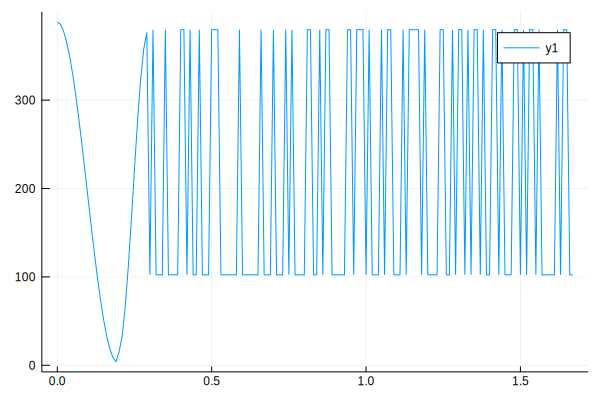

In [32]:
z = []
f = []
for li in sol[3].u
    append!(z, li[3])
    append!(f, k1k2Force(li, p[3])[3])
end
plot(sol[3].t, f)